In [1]:
import torch
from torchmetrics.classification import Accuracy, MulticlassCalibrationError, BinaryCalibrationError

# parameters
device = "cpu"
exp_lst = [
    "paws_x_mbert_fft_oob_none", 
    "paws_x_mbert_fft_ls_none", 
    "paws_x_mbert_fft_ts_none", 
    "paws_x_xlmr_fft_oob_none", 
    "paws_x_xlmr_fft_ls_none", 
    "paws_x_xlmr_fft_ts_none"
]
lang_lst = ["es", "ja"]

def flatten_list(lst):
    return [item for sublist in lst for item in sublist]

data = {}
for exp in exp_lst:
    if "xnli" in exp:
        acc = Accuracy(task="multiclass", num_classes=3).to(device)
        ece = MulticlassCalibrationError(num_classes=3, n_bins=10, norm="l1").to(device)
    else:
        acc = Accuracy(task="binary")
        ece = BinaryCalibrationError(n_bins=10, norm="l1")
    data[exp] = {}
    for lang in lang_lst:
        data[exp][lang] = {}
        conf_lst = []
        pred_lst = []
        prob_lst = []
        label_lst = []
        for seed in range(5):
            all_pred = torch.load(f"results/pred/{exp}/seed_{seed}/pred_{lang}", map_location=device)
            for batch in all_pred:
                conf_lst.append(batch[0].softmax(dim=1).max(dim=1)[0])
                pred_lst.append(batch[0].softmax(dim=1).max(dim=1)[1])
                prob_lst.append(batch[0].softmax(dim=1))
                label_lst.append(batch[1])
        conf_tensor = torch.cat(conf_lst)
        pred_tensor = torch.cat(pred_lst)
        label_tensor = torch.cat(label_lst)
        if "xnli" in exp:
            ece_score = ece(torch.cat(prob_lst).view(-1, 3), label_tensor)
        else:
            ece_score = ece(torch.cat(prob_lst).view(-1, 2)[:, 1], label_tensor)
        data[exp][lang] = {
            "conf": conf_tensor,
            "pred": pred_tensor,
            "label": label_tensor,
            "ece": ece_score
        }
        if "xnli" in exp:
            num_bin = 7
            bin_floor = 0.3
        else:
            num_bin = 5
            bin_floor = 0.5
        bin_acc = []
        bin_conf = []
        bin_samples = []
        for bin in range(num_bin):
            bin_idx = (bin_floor + 0.1 * bin <= conf_tensor) & (conf_tensor < bin_floor + 0.1 * (bin + 1))
            bin_conf.append(conf_tensor[bin_idx].mean())
            bin_pred = pred_tensor[bin_idx]
            bin_label = label_tensor[bin_idx]
            bin_acc.append(acc(bin_pred, bin_label))
            bin_samples.append(len(pred_tensor[bin_idx]))
        data[exp][lang]["bin_acc"] = bin_acc
        data[exp][lang]["bin_conf"] = bin_conf
        data[exp][lang]["bin_samples"] = bin_samples

/home/mgaber/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mgaber/miniconda3/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


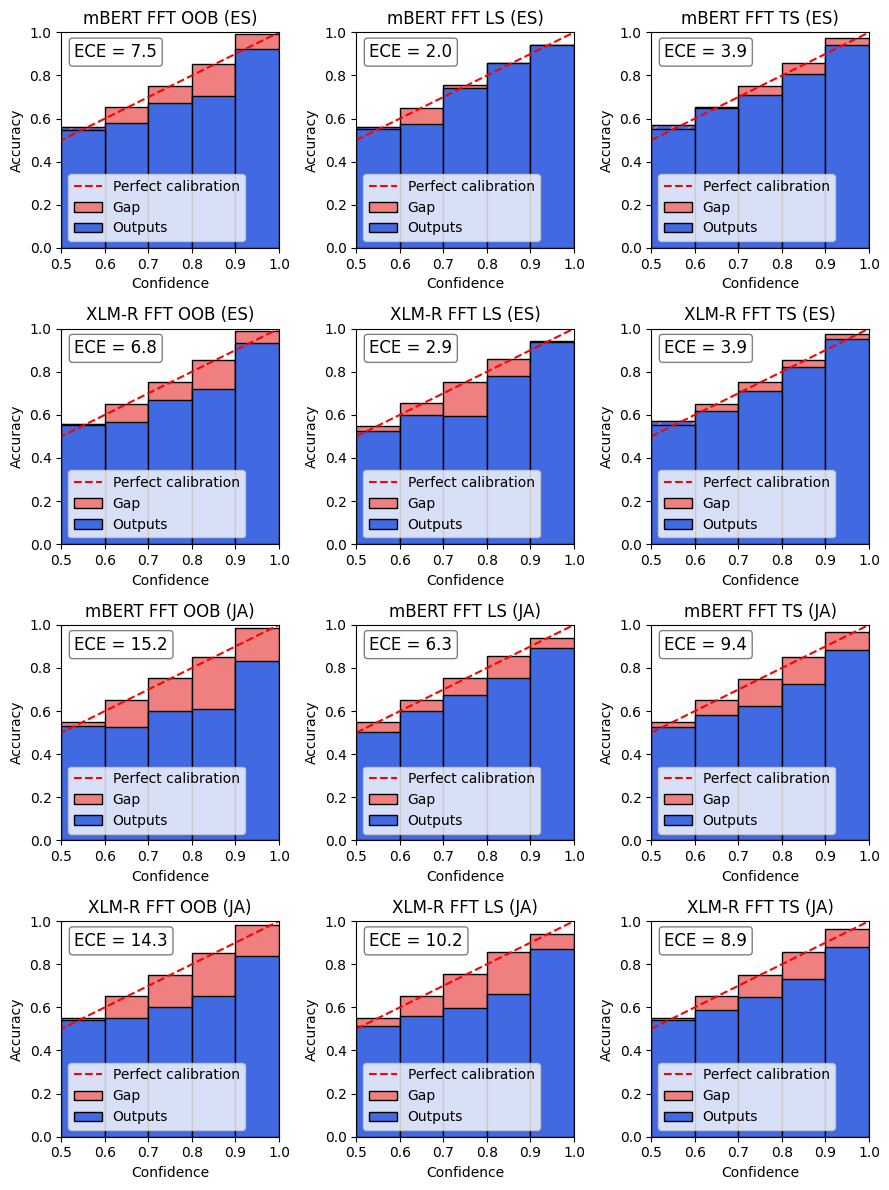

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### parameters ###
exp_lst = [
    "paws_x_mbert_fft_oob_none",
    "paws_x_mbert_fft_ls_none",
    "paws_x_mbert_fft_ts_none",
    "paws_x_xlmr_fft_oob_none",    
    "paws_x_xlmr_fft_ls_none",
    "paws_x_xlmr_fft_ts_none"
]
lang_lst = ["es", "ja"]
num_bin = 10
num_labels = 2
### ###

bar_width = 1 / num_bin
positions = np.arange((1/num_labels + bar_width/2), 1.0, 0.1)

fig, axs = plt.subplots(4, 3, figsize=(9, 12))

exp_lst = exp_lst * len(lang_lst)
lang_lst = [lang for lang in lang_lst for _ in range(len(exp_lst) // len(lang_lst))]

for _, (ax, exp, lang) in enumerate(zip((axs.flatten()), exp_lst, lang_lst)):
    conf_val = np.array(data[exp][lang]["bin_conf"])
    acc_val = np.array(data[exp][lang]["bin_acc"])

    foreground_idx = np.array([x for x in range(len(acc_val))], dtype=int)
    background_idx = np.array([], dtype=int)
    for idx, (conf, acc) in enumerate(zip(conf_val, acc_val)):
        if acc > conf:
            background_idx = np.append(background_idx, idx)
            foreground_idx = foreground_idx[foreground_idx != idx]

    label_outputs = "_no_legend_" if len(background_idx) > 0 else "Outputs"
    ax.bar(positions[foreground_idx], conf_val[foreground_idx], width=bar_width, color="lightcoral", edgecolor="black", align='center', label="Gap")
    ax.bar(positions[foreground_idx], acc_val[foreground_idx], width=bar_width, color="royalblue", edgecolor="black", align='center', label=label_outputs)

    if len(background_idx) > 0:
        ax.bar(positions[background_idx], acc_val[background_idx], width=bar_width, color="royalblue", edgecolor="lightcoral", align='center', hatch='//')
        # bar to make the edge black
        ax.bar(positions[background_idx], acc_val[background_idx], width=bar_width, facecolor=(0, 0, 0, 0), edgecolor="black", align='center')
        ax.bar(positions[background_idx], conf_val[background_idx], width=bar_width, color="royalblue", edgecolor="black", align='center', label="Outputs")

    ece = data[exp][lang]["ece"].item() * 100
    ax.plot([0, 1.0], [0, 1.0], 'r--', label="Perfect calibration")
    ax.text(0.53, 0.95, f"ECE = {ece:.1f}", ha='left', va='top', fontsize=12, color='black',
            bbox=dict(facecolor='white', edgecolor='grey', boxstyle="round,pad=0.3,rounding_size=0.2"))
    
    ax.set_xlim(0.50, 1.0)
    ax.set_ylim(0.0, 1.0)

    exp = f"{" ".join(exp.upper().replace("_", " ").replace("PAWS X", "PAWS-X").replace("MBERT", "mBERT").replace("XLMR", "XLM-R").split(" ")[1:4])} ({lang.upper()})"
    ax.set_title(exp)
    ax.set_xlabel("Confidence")
    ax.set_ylabel("Accuracy")
    ax.legend(loc="lower left")

plt.tight_layout()
plt.show()
fig.savefig("calibration.png", dpi=300)